In [6]:
# multilabelStratifiedKfold
import os
import json
import numpy as np
import pandas as pd
import argparse

from tqdm import tqdm

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# image 경로
data_path = '/opt/ml/detection/dataset'
images_path = os.path.join(data_path, 'train')

# annotation 경로
annotations_path = os.path.join('./train_new.json')

# 생성할 fold 개수
kfold = 5

# 생성된 fold를 저장할 폴더 경로 지정
path = './upsampling_stratified_kfold'

# Stratified kfold 진행
def main():
    with open(annotations_path, 'r') as f:
        train_json = json.loads(f.read())
        images = train_json['images']
        categories = train_json['categories']
        annotations = train_json['annotations']

    annotations_df = pd.DataFrame.from_dict(annotations)
    x = images
    y = [[0] * len(categories) for _ in range(len(images))]
    for anno in annotations:
        y[anno['image_id']][anno['category_id']] += 1

    mskf = MultilabelStratifiedKFold(n_splits=kfold, shuffle=True)


    if not os.path.exists(path):
        os.mkdir(path)

    for idx, (train_index, val_index) in tqdm(enumerate(mskf.split(x, y)), total=kfold):
        train_dict = dict()
        val_dict = dict()
        for i in ['info', 'licenses', 'categories']:
            train_dict[i] = train_json[i]
            val_dict[i] = train_json[i]
        train_dict['images'] = np.array(images)[train_index].tolist()
        val_dict['images'] = np.array(images)[val_index].tolist()
        train_dict['annotations'] = annotations_df[annotations_df['image_id'].isin(train_index)].to_dict('records')
        val_dict['annotations'] = annotations_df[annotations_df['image_id'].isin(val_index)].to_dict('records')

        train_dir = os.path.join(path, f'cv_train_{idx + 1}.json')
        val_dir = os.path.join(path, f'cv_val_{idx + 1}.json')
        with open(train_dir, 'w') as train_file:
            json.dump(train_dict, train_file)

        with open(val_dir, 'w') as val_file:
            json.dump(val_dict, val_file)

    print("Done Make files")


# if __name__ == "__main__":
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--path', '-p', type=str, default='./stratified_kfold')
#     parser.add_argument('--n_split', '-n', type=int, default=5)
#     arg = parser.parse_args()
#     main(arg)
main()

100%|██████████| 5/5 [00:13<00:00,  2.67s/it]

Done Make files


loading annotations into memory...
Done (t=0.37s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.40s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.40s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


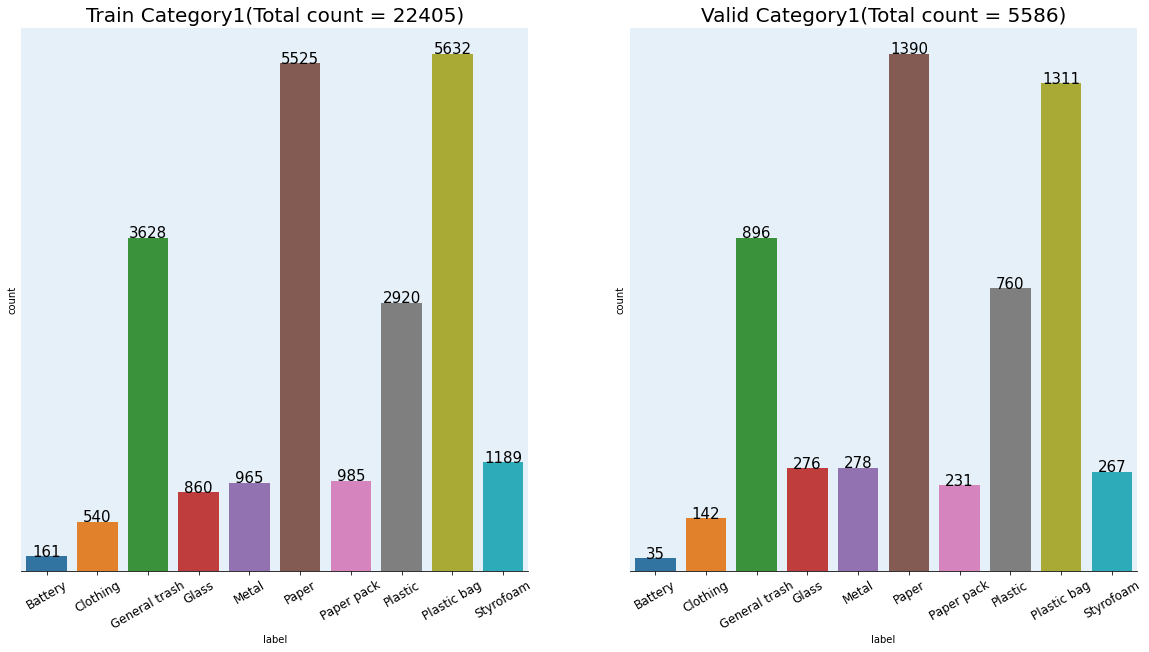

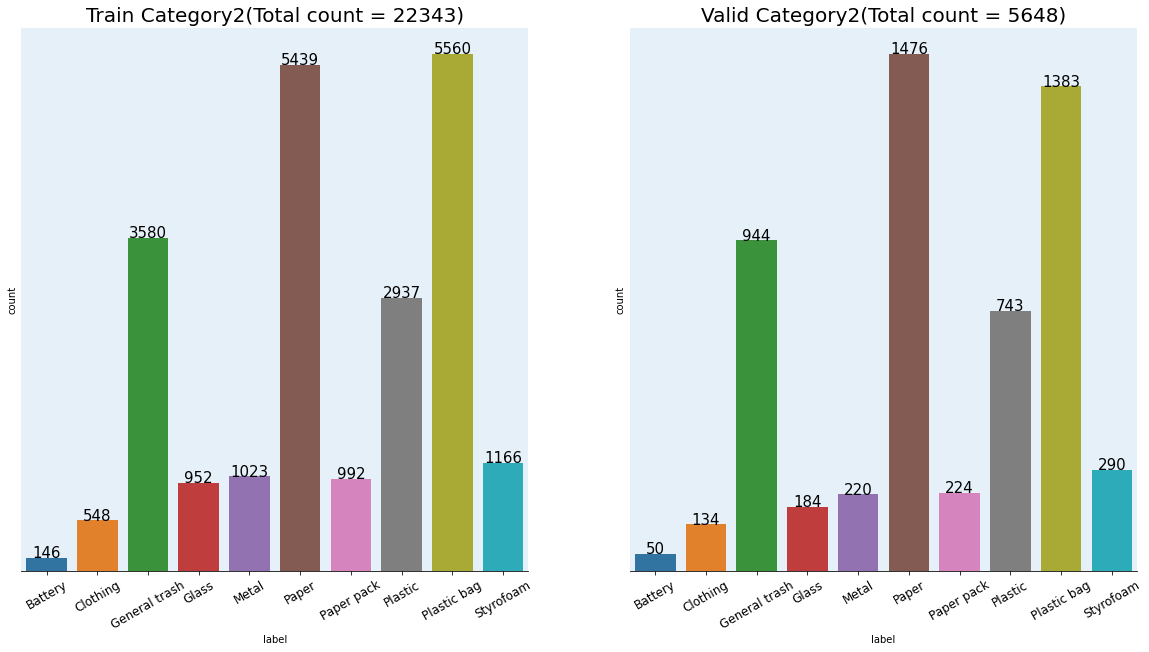

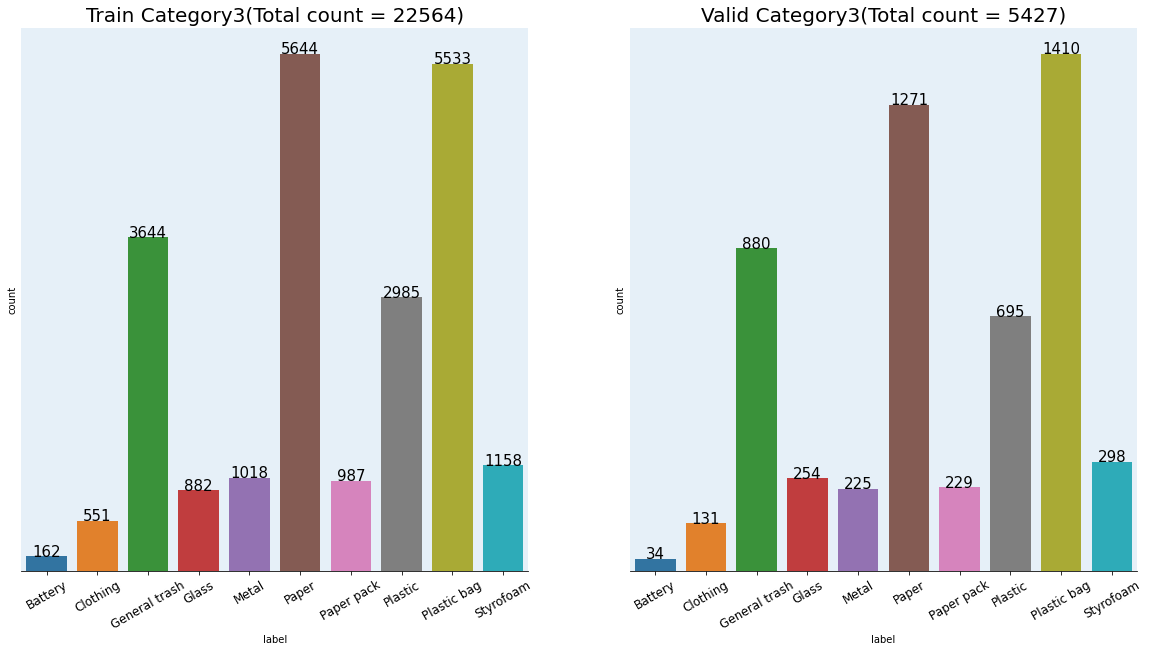

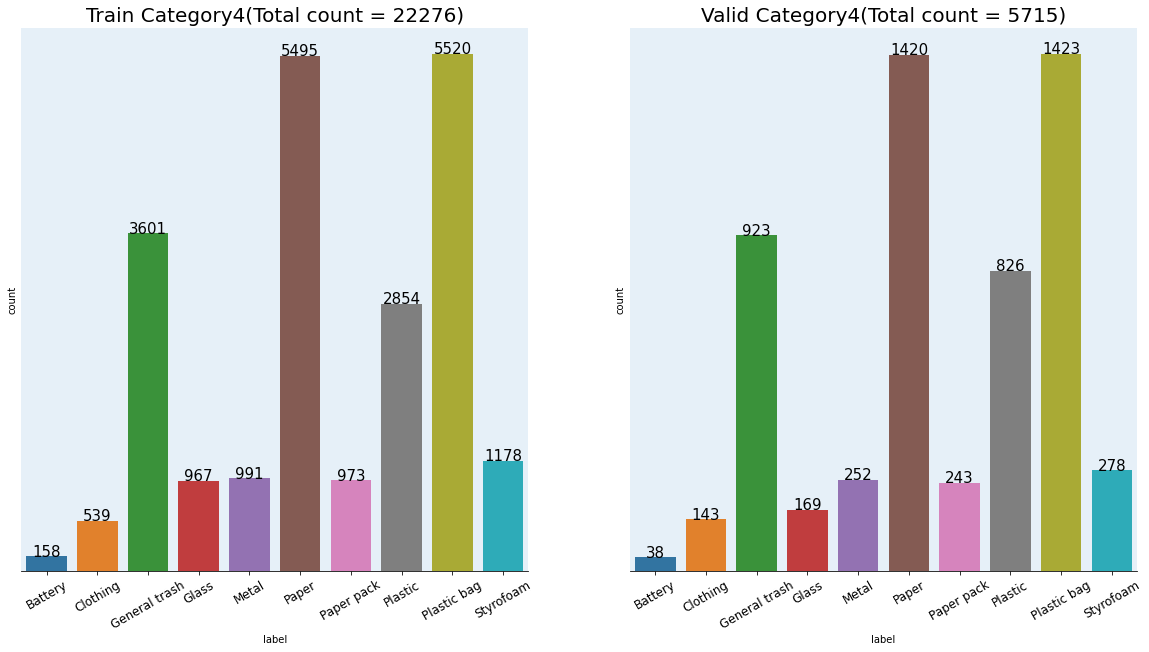

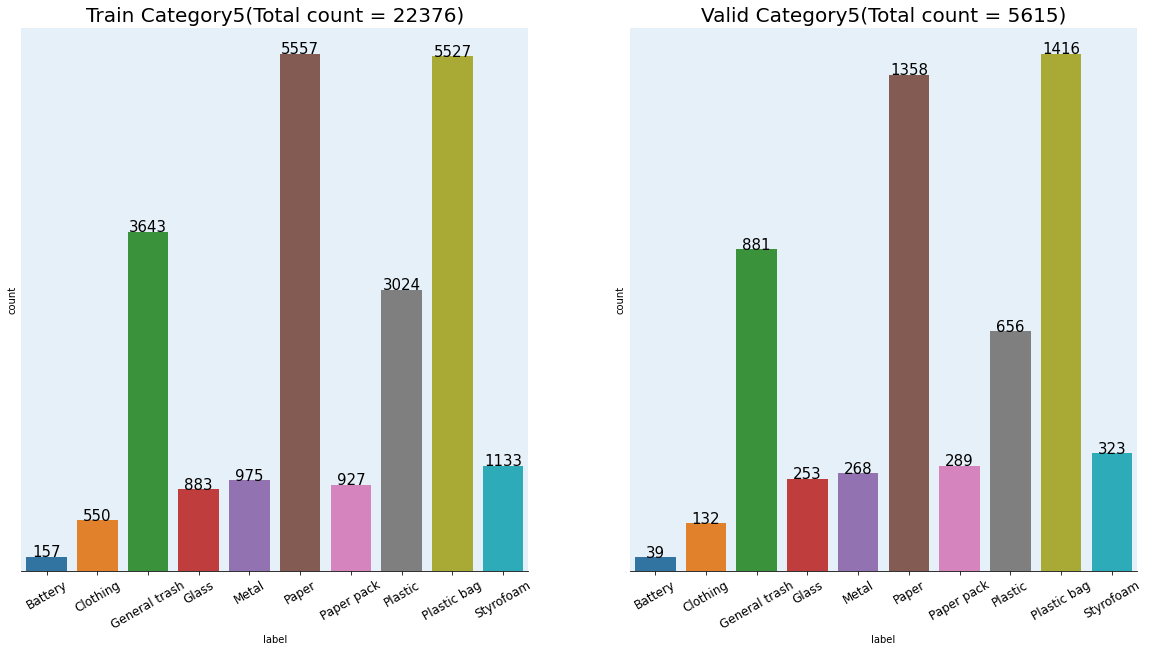

In [8]:
# 각 fold 별 분포 확인
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json
from tqdm import tqdm
from pycocotools.coco import COCO

# train/valid 경로
train_path = './upsampling_stratified_kfold/cv_train_'
valid_path = './upsampling_stratified_kfold/cv_val_'


def ToDataFrame(coco):
    gt = []
    for img_id in coco.getImgIds():
        img_info = coco.loadImgs(img_id)[0]
        file_name = img_info['file_name']
        annotation_id = coco.getAnnIds(img_id)
        annotation_info = coco.loadAnns(annotation_id)
        for an in annotation_info:
            x_min,y_min,w,h = an["bbox"][0],an["bbox"][1],an["bbox"][2],an["bbox"][3]
            image_id = an["category_id"]
            gt.append([file_name,image_id,float(x_min),(float(x_min) + float(w)), float(y_min),(float(y_min)+float(h))])
    GT_df = pd.DataFrame(gt,columns=["file_name","label","x_min","x_max","y_min","y_max"])
    return GT_df

# 각 label 개수/비율 확인
def check():
    for i in range(1,kfold+1):
        train_json = train_path + str(i) + '.json'
        valid_json = valid_path + str(i) + '.json'
        train_coco = COCO(train_json)
        val_coco = COCO(valid_json)


        train_df = ToDataFrame(train_coco)
        valid_df = ToDataFrame(val_coco)
        LABEL_NAME = ["General trash", "Paper", "Paper pack", "Metal", 
                      "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

        label_dict = {}
        for idx,name in enumerate(LABEL_NAME):
            label_dict[idx] = name

        train_df["label"] = train_df["label"].apply(lambda x: label_dict[x])
        valid_df["label"] = valid_df["label"].apply(lambda x: label_dict[x])
        
        # 같은 이미지가 train,test 로 나뉘었는지 확인
        # for img in set(valid_df['file_name']):
        #     if img in set(train_df['file_name']):
        #         print('warning data leakage!!')
        
        plt.figure(figsize=(20,10))

        for j in range(2):
            if j == 0:
                df = train_df
                title = 'Train'
            else:
                df = valid_df
                title = 'Valid' 
            
            df = df.sort_values('label')
            plt.subplot(1,2,j+1)
            ax = sns.countplot(x=df['label'])

            for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x() + p.get_width() / 2., height, height,ha = 'center', size = 15)

            plt.title(title + " Category" + str(i) + '(Total count = ' + str(len(df)) + ')',size=20)
            plt.gca().spines['right'].set_visible(False)
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['left'].set_visible(False)
            plt.yticks([])
            plt.xticks(rotation=30,size=12)
            plt.gca().set_facecolor('#E6F0F8')

check()